**Abstract**

The data we have in this assignment has more than 3300 features, brought down to 2600 features after technical pre-processing, and just over 1700 samples. The samples/rows have duplicate measurements for the same milk sample ( up-to 12 replicates). This was perhaps done to account for measurement errors. In reality we have 155 milk samples in the training data-set and 76 on test data.

This makes approaches on previous assignments (on tall data) like feature selection unusable, or time-consuming. Naturally, the features are very highly correlated to each other, as described in the Hoggorm correlation plots below. So there were two main challenges: Several features with multicollinearity, and replicates in the samples.

The first problem can be solved by using dimensionality reduction (feature extraction). We have used PCA and PLS  for this, while RandomForestRegression and PLSR(PLS+OLS) are the subsequent predictors used on the reduced data. We have also tried to reduce overfitting by using bagging and elasticNet. Outlier removal was attempted for the spikes that were appearing on the spectral plot.

The second problem ( replicates) was tackled by both fitting and predicting the model only with the mean measure of the replicates. This gave superior results to the approach of fitting and predicting on the whole dataset with duplicates. We also tried the approach of training on the whole data, predicting on the whole data, and then taking the median/mean of the prediction, which also gave impressive result. Finally, overfitting correction approach like bagging and Elastinet also showed similar, but not the best result. Perhaps there is more to explore!

# Read input files and define function

In [1]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

#==============================================================================
#  Define EMSC
#==============================================================================
#%% Extended multiplicative signal correction
def EMSC(X, reference, degree=4):
    # Create polynomials up to chosen degree
    poly = []; pvar = [1]
    for i in range(degree):
        poly.append( np.polyval(pvar,np.linspace(-1,1,len(reference))) )
        pvar.append(0)
    # Reference spectrum and polynomials
    emsc_basis = np.vstack([reference, np.vstack(poly)])
    # Estimate EMSC parameters
    (params,_,_,_) = np.linalg.lstsq(emsc_basis.T, X.T, rcond=None)
    # Correct and return
    return (X - params[1:,:].T @ emsc_basis[1:,:])/params[:1,:].T


#==============================================================================
#  Read train and test file
#==============================================================================
pickle_train = open("train.pkl","rb")
train_object = pickle.load(pickle_train)
pickle_test = open("test.pkl","rb")
test_object = pickle.load(pickle_test)

#==============================================================================
#  Read dictionary objects into arrays and Matrices
#==============================================================================
columns = train_object['shifts'].flatten()
X_train = train_object['RamanCal']
y_train = train_object['IodineCal']
replicates_train = train_object['repCal']

X_test = test_object['RamanVal']
replicates_test = test_object['repVal']

# Technical preprocessing

In [3]:
#==============================================================================
#  Keep only the shifts between 500 and 3100- train aand test
#==============================================================================
X_cut_train = X_train[ :, (columns>=500) & (columns<=3100)]
colnames = columns[ (columns>=500) & (columns<=3100) ]
X_emsc_train = EMSC(X_cut_train, X_cut_train[1343, :]  , degree=7)

X_cut_test = X_test[ :, (columns>=500) & (columns<=3100)]
X_emsc_test = EMSC(X_cut_test, X_cut_train[1343, :]  , degree=7)

# Creating DataFrames which are used later

In [4]:
#==============================================================================
#  Create dataframes for data visualization
#==============================================================================
col_str = list( map( str, colnames))
col_str.insert(0,'replicates')

test_df = pd.DataFrame( np.concatenate( (replicates_test[:, np.newaxis ]
            , X_emsc_test), axis =1), columns= col_str)

col_str.append('Iodine')

train_df = pd.DataFrame( np.concatenate( (replicates_train[:, np.newaxis ]
            , X_emsc_train, y_train), axis =1)
            , columns= col_str)

# Some EDA 
- Since they have similar standard deviation and mean, we could say that the train set and test set are similar.
- Just the minimum value seems to be much lesser in case of train data

In [5]:
print('Train data:')
print( 'Max: ', X_emsc_train.max(),'Min: ',X_emsc_train.min(),'Avg: ' , X_emsc_train.mean(),'Std: ' , X_emsc_train.std() )
print('Test data:')
print( 'Max', X_emsc_test.max(),'Min', X_emsc_test.min(),'Avg: ' , X_emsc_test.mean() ,'Std: ' , X_emsc_test.std() )

Train data:
Max:  55733.27612485042 Min:  1581.9135386188814 Avg:  9578.707219530945 Std:  7450.607883448042
Test data:
Max 59184.6262267195 Min 3220.7337720180763 Avg:  9578.707219530937 Std:  7448.209530634847


In [6]:
pd.DataFrame(y_train).describe()

,0
count,1796.000000
mean,24.755636
std,3.472541
min,18.387700
25%,22.615000
50%,23.935500
75%,26.365300
max,43.923200


**Is a RMSE of 0.7 good enough for a range of target from 24 to 44!**

# Plot the train and test spectra

In [7]:
x_axis = train_df.columns[1:-1].astype(np.int)

In [8]:
train_df.iloc[:1 , 1:-1].values.flatten()
print(type(train_df.iloc[:1 , 1:-1].values.flatten()))
print(train_df.iloc[:1 , 1:-1].values.flatten().shape)

<class 'numpy.ndarray'>
(2601,)


In [9]:
train_df['Iodine'][0] 

33.4127

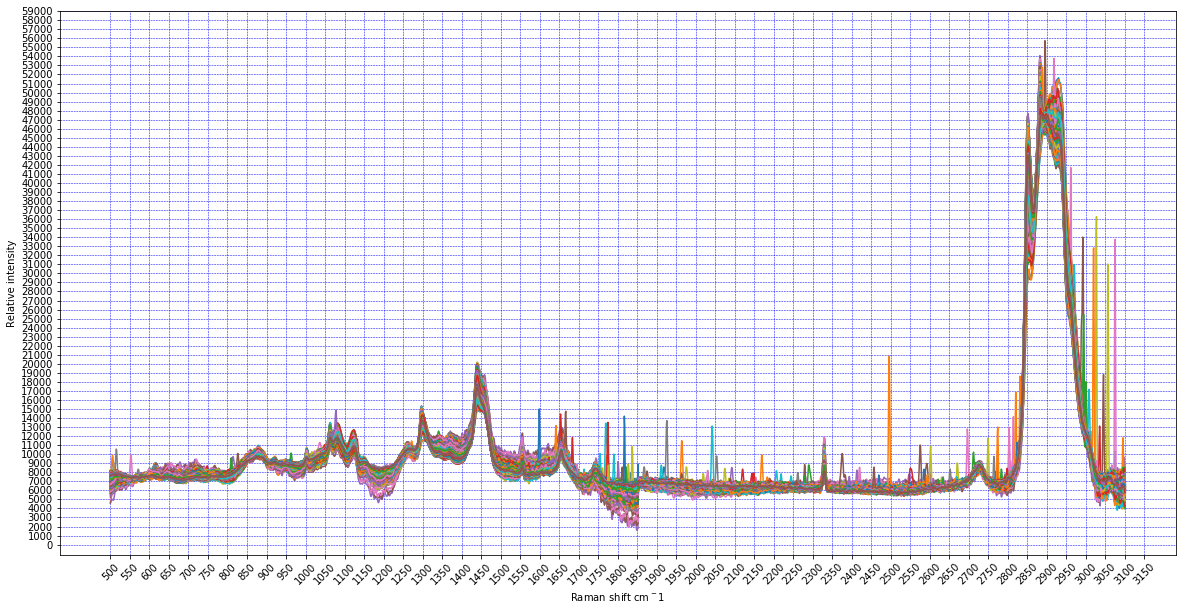

In [10]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(train_df.shape[0]):
    plt.plot( x_axis , train_df.iloc[i , 1:-1].values.flatten(),'-'  ) 

plt.xlabel('Raman shift cm$^-1$')
plt.ylabel('Relative intensity')
plt.xticks(np.arange(500, 3200, 50), rotation=45)
plt.yticks(np.arange(0, 60000, 1000))
# Customize the major grid
plt.grid(which='major', linestyle='--', linewidth='0.5', color='blue')
plt.show()

## In test dataset

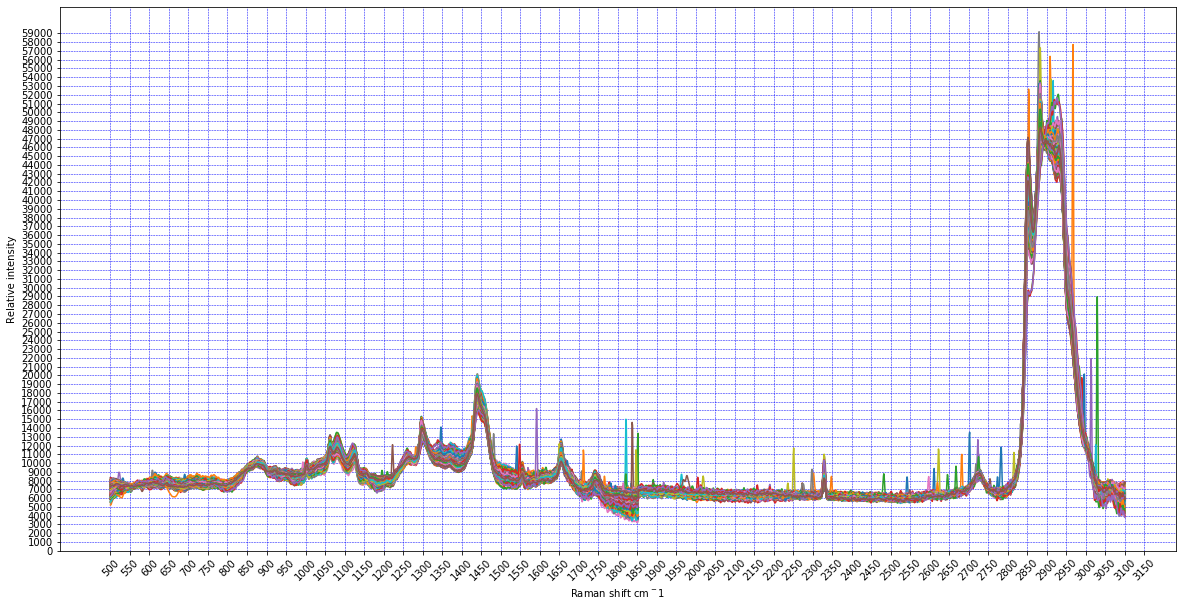

In [11]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(test_df.shape[0]):
    plt.plot( x_axis , test_df.iloc[i , 1:].values.flatten(),'-'  ) 

plt.xlabel('Raman shift cm$^-1$')
plt.ylabel('Relative intensity')
plt.xticks(np.arange(500, 3200, 50), rotation=45)
plt.yticks(np.arange(0, 60000, 1000))
# Customize the major grid
plt.grid(which='major', linestyle='--', linewidth='0.5', color='blue')
plt.show()


*There is no significant, but some difference at places between training and test spectrum.*
- **Should we consider these rows as outliers. Dealt with below** 

# Hoggorm PCA plots
- Interactive plots used for better visualization

In [12]:
#==============================================================================
# Loadings and Scores plot Hoggorm, Take average among replicates
# Source: https://github.com/olivertomic/hoggorm/tree/master/examples
#==============================================================================
import hoggorm as ho
import hoggormplot as hop

train_avg_df = train_df.iloc[:, :-1].groupby('replicates').mean()

# Get the values from the data frame
data = train_avg_df.values

# Get the variable or columns names
data_varNames = list(train_avg_df.columns)

# Get the object or row names
data_objNames = list (  map( int, list(train_avg_df.index)) )

model = ho.nipalsPCA(arrX=data, Xstand=False, cvType=["loo"], numComp=4)


loo


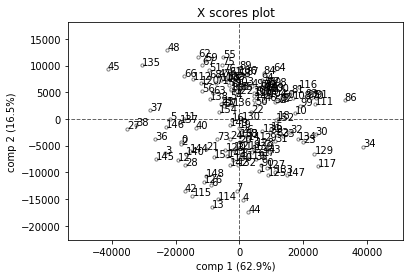

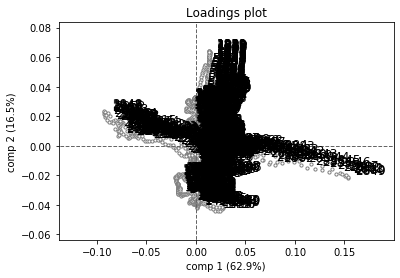

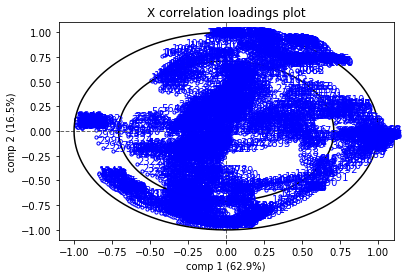

In [17]:
# %matplotlib qt5 # For zooming in and out
%matplotlib inline
hop.plot(model, comp=[1,2], 
         plots=[1,2,3], 
         objNames=data_objNames, 
         XvarNames=data_varNames)


**Components 2 and 3 also showed considerable variation. The points are more densely packed in the direction of 2nd and 3rd components, than the first**

# Try with PCA and RandomForestRegression

In [8]:
rf_pipe = make_pipeline(  StandardScaler(),
                        PCA(n_components=10),
                        RandomForestRegressor( n_estimators=100, max_depth= 100, n_jobs=-1) )

## K fold grouping strategy, Randomising how the groups are assigned

In [9]:
from sklearn.model_selection import GroupKFold
groups = np.asarray( [])
import random
random.seed(3)

# Create 31 groups, 31 cross validations
my_list = list(range(1,32))

for i in  range( 1, 32 ) :
    random_item_from_list =random.choice(my_list)    
    my_list.remove(random_item_from_list)
    lower_limit = (i-1)*5
    upper_limit = (i)*5 
    rand_append_nos = sum ( (train_df.replicates < upper_limit)& (train_df.replicates >=lower_limit) )
    groups = np.concatenate( (groups, np.repeat(random_item_from_list,rand_append_nos)),axis=None ) 
print(len(groups))
print( set(groups))

1796
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0}


In [10]:
gkf = GroupKFold(10)

In [11]:
for train_id, test_id in gkf.split(X_emsc_train, y_train.flatten(), groups):
    print(len(train_id), len( test_id), end=' ; ')

1619 177 ; 1619 177 ; 1619 177 ; 1619 177 ; 1622 174 ; 1622 174 ; 1577 219 ; 1625 171 ; 1620 176 ; 1622 174 ; 

## Start GridSearchCV

In [12]:
depth_range = [ 80,90,100,110] 
features_range = [4,5,6,7,8,9,10] 

param_grid = [ {'randomforestregressor__max_depth': depth_range
                , 'randomforestregressor__max_features': features_range } ]

gs = GridSearchCV(estimator=rf_pipe,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=gkf,
                n_jobs=-1,
                refit=True,
                iid= True,
                 verbose=0)

In [13]:
gs = gs.fit(X_emsc_train, y_train.flatten(), groups= groups )

In [14]:
print(gs.best_score_)
print(gs.best_params_)

-5.709405475583833
{'randomforestregressor__max_depth': 90, 'randomforestregressor__max_features': 6}


**Not a good result from PCA+RandomforestRegressor**

# More PCA - with just mean of the replicates in both training and test dataset

In [143]:
# Try running with just the averages
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

In [144]:
rf_pipe = make_pipeline(  #StandardScaler(),
                        PCA(n_components=10),
                        RandomForestRegressor( n_estimators=200, max_depth= 10, n_jobs=-1) )

In [145]:
depth_range = [ 5,10,20,40] 
features_range = [4,5,6,7,8,9,10] 

param_grid = [ {'randomforestregressor__max_depth': depth_range
                , 'randomforestregressor__max_features': features_range } ]

gs = GridSearchCV(estimator=rf_pipe,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                iid= True,
                 verbose=False)


In [146]:
gs = gs.fit( train_avg_df.iloc[:, :-1] ,train_avg_df.iloc[:, -1:].values.flatten()  )

In [147]:
print(gs.best_score_)
print(gs.best_params_)

-4.666893176600628
{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 8}


In [148]:
y_test_pred = gs.predict( test_avg_df.iloc[:, :]  )
output = pd.DataFrame( y_test_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("submission_pca_avg.csv", index=False)

**Got around 2.27 with this one**

# PLSR- Ran on the whole training set, with all replicates

In [158]:
pls6 = PLSRegression(n_components=25, scale=False, max_iter= 5000)
pls6.fit(X_emsc_train, y_train.flatten() )

PLSRegression(copy=True, max_iter=5000, n_components=25, scale=False, tol=1e-06)

In [159]:
print( mean_squared_error(y_train.flatten(), pls6.predict(X_emsc_train) ))
y_test_pred = pls6.predict(X_emsc_test)

0.39978828976528963


In [8]:
comp_range = [ 14,15,16,17,24,30,32,33,34] 
scale_range = [True, False] 
max_iter_range = [200]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range}
             ]


gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=gkf,
                n_jobs=-1,
                refit=True,
                 iid=False,
                 verbose=False)

In [9]:
gs = gs.fit(X_emsc_train, y_train.flatten() , groups=groups)

In [10]:
print(gs.best_score_)
print(gs.best_params_)

-1.2816219994490907
{'plsregression__max_iter': 200, 'plsregression__n_components': 14, 'plsregression__scale': False}


In [12]:
y_test_pred = gs.predict( X_emsc_test )

In [14]:
output = pd.DataFrame( y_test_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("submission_average_later.csv", index=False)

**This one gave 1.27 in kaggle**

# More PLSR - second best prediction

In [166]:
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

In [167]:
comp_range = [ 14,15,16,17,18] 
scale_range = [True, False] 
max_iter_range = [10,20,50,100,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range} ]

gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                iid= False,
                  verbose=0)

In [168]:
gs = gs.fit( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )

In [169]:
print(gs.best_score_)
print(gs.best_params_)

-0.34293430892609794
{'plsregression__max_iter': 10, 'plsregression__n_components': 14, 'plsregression__scale': False}


In [170]:
output = pd.DataFrame( gs.predict( test_avg_df.iloc[:,:].values))
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsr_1.csv", index=False)

**MSE on the train dataset. Overfitting??**

In [171]:
mean_squared_error(  train_avg_df['Iodine'].values , gs.predict( train_avg_df.iloc[:,:-1].values )  )

0.052466510927491945

# Outlier consideration - Best prediction

## In Train data

In [172]:
pot_outlier =  np.asarray(  np.where( (x_axis<=2650) & ( x_axis>1800  )  ) ).flatten()
bool_mat = X_emsc_train[:, pot_outlier ]>12000
outlier_present = []
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        outlier_present.append(i)

pot_outlier =  np.asarray(  np.where(  x_axis>3000  )  ).flatten()
bool_mat = X_emsc_train[:, pot_outlier ]>25000

for i, row in enumerate(bool_mat):
    if sum(row)>0:        
        outlier_present.append(i)

outliers_rows = set(outlier_present)

In [173]:
print( outliers_rows)

{736, 801, 611, 1418, 459, 18, 1790, 767}


In [174]:
train_dfo = train_df.drop( outliers_rows )
train_dfo.shape

(1788, 2603)

## In Test Data

In [175]:
pot_outlier =  np.asarray(  np.where( (x_axis<=2650) & ( x_axis>1800  )  ) ).flatten()
bool_mat = X_emsc_test[:, pot_outlier ]>12000

outlier_present = []
for i, row in enumerate(bool_mat):
    if sum(row)>0:
        outlier_present.append(i)

pot_outlier =  np.asarray(  np.where(  x_axis>3000  )  ).flatten()
bool_mat = X_emsc_test[:, pot_outlier ]>25000

for i, row in enumerate(bool_mat):
    if sum(row)>0:        
        outlier_present.append(i)

outliers_rows = set(outlier_present)

In [176]:
print( outliers_rows)

{162, 339, 252, 325}


In [177]:
test_dfo = test_df.drop( outliers_rows )
test_dfo.shape

(882, 2602)

## Now , after removing outlier and run PLSR

In [178]:
train_avg_df = train_dfo.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_dfo.iloc[:, :].groupby('replicates').mean()

In [179]:
comp_range = [10,11,12,13, 14,15,16] 
scale_range = [True, False] 
max_iter_range = [50,60,80,90,100,500]

pls6 = make_pipeline( PLSRegression() )

param_grid = [ {'plsregression__n_components': comp_range
                , 'plsregression__scale': scale_range
                , 'plsregression__max_iter': max_iter_range} ]

gs = GridSearchCV(estimator=pls6,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=10,
                n_jobs=-1,
                refit=True,
                 iid= False,
                  verbose=False)


In [180]:
gs = gs.fit( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )

In [181]:
print(gs.best_score_)
print(gs.best_params_)

-0.3314359555217047
{'plsregression__max_iter': 50, 'plsregression__n_components': 14, 'plsregression__scale': False}


In [182]:
output = pd.DataFrame( gs.predict( test_avg_df.iloc[:,:].values))
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsr_outlier4.csv", index=False)

**Distributed the same prediction for a particular replicate later in excel manipulation**

**MSE on the train dataset. Overfitting??**

In [183]:
mean_squared_error(  train_avg_df['Iodine'].values , gs.predict( train_avg_df.iloc[:,:-1].values )  )

0.051511552008470705

# Bagging - to reduce overfitting

In [184]:
from sklearn.ensemble import BaggingRegressor

In [185]:
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

In [186]:
clf = BaggingRegressor(base_estimator=PLSRegression(
                    n_components=14,
                    scale=False, tol=1e-06),
                    n_estimators=500,
                    random_state=0,
                    n_jobs = -1 ).fit(
    train_avg_df.iloc[:,:-1].values 
    , train_avg_df['Iodine'].values)

y_pred = clf.predict( test_avg_df.iloc[:,:].values)

In [187]:
output = pd.DataFrame( y_pred )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("avg_plsrb.csv", index=False)

In [188]:
mean_squared_error( train_avg_df['Iodine'].values , clf.predict( train_avg_df.iloc[:,:-1].values ) )

0.08004137732448012

**Less overfitting now**

# PLS Regression as a intermediate step - Regularized
## Third best result

In [189]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

In [190]:
train_avg_df = train_df.iloc[:, :].groupby('replicates').mean()
test_avg_df = test_df.iloc[:, :].groupby('replicates').mean()

**Using a wrapper class for PLSRegression**

**Source for code - kristian.liland@nmbu.no**

In [191]:
class PLSRegressionWrapper( PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit( X,Y).transform(X)

In [192]:
pls_wrap =  PLSRegressionWrapper(copy=True, max_iter=100, n_components=14,
                               scale=False, tol=1e-06)

In [193]:
pls_train = pls_wrap.fit_transform( train_avg_df.iloc[:,:-1].values , train_avg_df['Iodine'].values )
pls_train.shape

(155, 14)

In [194]:
pls_test = pls_wrap.transform(test_avg_df.iloc[:,:].values)
pls_test.shape

(77, 14)

In [195]:
y= train_avg_df['Iodine'].values

In [196]:
regr = ElasticNetCV(l1_ratio =  [0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 1] , cv=3, random_state=0)
regr = regr.fit(pls_train , y)

In [197]:
print(regr.alpha_)
print(regr.intercept_)

14.64137097490296
24.760859999999997


In [198]:
print( 'l1 ratio: ' , regr.l1_ratio_)
print( 'coeffs: ' , regr.coef_) 
print ('mse for all : ',  np.min( regr.mse_path_) )
print( 'alphas :' , np.min( regr.alphas_) )
print( ' number of iterations: ', regr.n_iter_ )

l1 ratio:  1.0
coeffs:  [-0.00039013  0.00012346  0.00042981  0.00027377 -0.00031605  0.00043853
 -0.00022825  0.00032238 -0.000516   -0.00073312  0.0005802  -0.00030465
 -0.00030284 -0.0003161 ]
mse for all :  0.056254418098045225
alphas : 14.64137097490296
 number of iterations:  2


In [199]:
y_test = regr.predict( pls_test)
output = pd.DataFrame( y_test )
output['Id'] = output.index
output=output.rename(columns={ 0: "label"})
output.to_csv("pls_elastinet.csv", index=False)

**Distributed the same prediction for a particular replicate later in excel manipulation**

In [200]:
mean_squared_error( y, regr.predict(pls_train))

0.05802574676205988

**MSE seems to be similar between ElasticCV and Training. Will put this as another in Kaggle**